In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [79]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_x",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)
print(repr(stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)))

cirq.Circuit([
    cirq.Moment(
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(0, 0)),
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(2, 0)),
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(4, 0)),
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(1, 1)),
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(3, 1)),
        stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key='', measure_flip_probability=0).on(cirq.GridQubit(0, 2)),
  

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [39]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [35]:

for i, anc in enumerate(ancillas):
    if anc.name[:2] == "ax":
        print(i, i - len(ancillas))

0 -8
1 -7
2 -6
3 -5


In [122]:
surface_code = qldpc.codes.SurfaceCode(3, rotated=True)
error_rate=0.01
repetitions = 10
circuit = cirq.Circuit()
stab_circuit = cirq.Circuit()

logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)

count = 0
measures = []
hs = []
for anc_idx, row in enumerate(surface_code.matrix_x):
    count += 1
    anc = cirq.NamedQubit(f"ax{anc_idx}")
    stab_circuit += cirq.H(anc)
    for bit_idx, bit in enumerate(row):
        if bit:
            stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
            stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
    stab_circuit += cirq.H(anc)
    # hs.append(cirq.H(anc))
    measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc))

stab_circuit += cirq.Moment(measures)
measures = []

# stab_circuit += css.barrier(*stab_circuit.all_qubits())



for anc_idx, row in enumerate(surface_code.matrix_z, start=count):
    anc = cirq.NamedQubit(f"az{anc_idx}")
    stab_circuit += cirq.H(anc)
    for bit_idx, bit in enumerate(row):
        if bit:
            stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
            stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
    stab_circuit += cirq.H(anc)
    measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc))

stab_circuit += cirq.Moment(measures)
# First round of stabilizer checks
circuit = stab_circuit.copy()

# circuit += cirq.Moment(measures)

ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

# circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
indices = [(i, i - len(ancillas)) for i, anc in enumerate(ancillas) if anc.name[:2] == "ax"]
circuit += cirq.Moment([stimcirq.DetAnnotation(parity_keys=[f"{i}"], coordinate_metadata = (i, 0)) for i, x in indices])
# Make this work for general code



# Repeat Block
circuit_op = stab_circuit.copy()
# moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
moment = cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
circuit_op += moment
circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x, x-len(ancillas)], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), 0))])
# Make this work for general code
circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))


circuit

┌──┐   ┌──────────────┐   ┌───────────────┐   ┌────────┐   ┌────────┐   ┌─────────┐   ┌──────────┐   ┌────────┐   ┌────────┐   ┌────────┐   ┌────────┐
                                                                                                                                                                                                                          [                   ┌──┐   ┌──────────────┐   ┌───────────────┐   ┌────────┐   ┌────────┐   ┌─────────┐   ┌──────────┐   ┌────────┐   ┌────────┐   ┌────────┐   ┌────────┐                                                                                   ]
                                                                                                                                                                                                                          [ 0: ─────D(0.01)────X──────D(0.01)──────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                          [                    │                                       │                                                                                                                                                                                               ]
                                                                                                                                                                                                                          [ 1: ─────D(0.01)────┼──────X──────────────────D(0.01)───────┼────────────@─────D(0.01)──────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                          [                    │      │                                │            │                          │                                                                                                                                                       ]
                                                                                                                                                                                                                          [ 2: ─────D(0.01)────┼X─────┼──────D(0.01)───────────────────┼────────────┼──────────────────────────┼─────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                          [                    ││     │                                │            │                          │             │                                                                                                                                         ]
                                                                                                                                                                                                                          [ 3: ─────D(0.01)────┼┼─────┼──────────────────X─────────────┼─────D(0.01)┼────────────X─────D(0.01)─┼─────────────┼@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                 

In [177]:
surface_code = qldpc.codes.SurfaceCode(3, rotated=True)
# surface_code.reduce_logical_ops()

def gen_syndrome_surface_circuit(surface_code, repetitions=1, error_rate=0.01):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
    
    count = 0
    measures = []
    spam = []
    hs = []
    # Extracting X-type stabilizers
    for anc_idx, row in enumerate(surface_code.matrix_x):
        count += 1
        anc = cirq.NamedQubit(f"ax{anc_idx}")
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        stab_circuit += cirq.H(anc)
        # stab_circuit += cirq.X.with_probability(error_rate).on(anc)
        # stab_circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc)
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc))        
        spam.append(cirq.X.with_probability(error_rate).on(anc))

    stab_circuit += cirq.Moment(spam)
    stab_circuit += cirq.Moment(measures)
    stab_circuit += cirq.Moment(spam)
    measures = []
    spam = []

    
    # stab_circuit += css.barrier(*stab_circuit.all_qubits())
    
    # Extracting Z-type stabilizers
    for anc_idx, row in enumerate(surface_code.matrix_z, start=count):
        anc = cirq.NamedQubit(f"az{anc_idx}")
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
        stab_circuit += cirq.H(anc)
        # stab_circuit += cirq.X.with_probability(error_rate).on(anc)
        # stab_circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc)
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=f"{anc_idx}").on(anc)) 
        spam.append(cirq.X.with_probability(error_rate).on(anc))
    stab_circuit += cirq.Moment(spam)
    stab_circuit += cirq.Moment(measures)
    stab_circuit += cirq.Moment(spam)
    measures = []
    spam = []
    
    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    # circuit += cirq.Moment(measures)

    # Isolating ancilla and data qubits for simplicity
    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    # circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas]) # Measurement Error

    # Apply detectors only on relevant stabilizer ancilla
    indices = [(i, i - len(ancillas)) for i, anc in enumerate(ancillas) if anc.name[:2] == "ax"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(parity_keys=[x], coordinate_metadata = (i, 0)) for i, x in indices])
    # Make this work for general code


    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    # moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    moment = cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    circuit_op += moment
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x, x-len(ancillas)], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), 0))])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))


    for idx, d in enumerate(data):
        circuit += cirq.Z.with_probability(error_rate).on(d) 
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    moment = []
    for i, anc_idx in enumerate(range(len(ancillas)//2)):
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))

    circuit += cirq.Moment(moment)

    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # circuit.insert(0, cirq.reset_each(*circuit.all_qubits()))
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)

    # return circuit.with_noise(cirq.depolarize(error_rate))
    return circuit

surface_circuit = gen_syndrome_surface_circuit(surface_code, 10)
# surface_circuit

In [175]:
gen_syndrome_surface_circuit(surface_code, 3*d, noise)

┌──┐   ┌──────────────────┐   ┌───────────────────┐   ┌──────────┐   ┌──────────┐   ┌───────────┐   ┌────────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐   ┌───────────────┐   ┌────────┐
                                                                                                                                                                                                                                                                                                                [                     ┌──┐   ┌──────────────────┐   ┌───────────────────┐   ┌──────────┐   ┌──────────┐   ┌───────────┐   ┌────────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐   ┌───────────────┐   ┌────────┐                                                                                                                        ]
                                                                                                                                                                                                                                                                                                                [ 0: ─────D(0.0316)────X──────D(0.0316)────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                                [                      │                                               │                                                                                                                                                                                                                                                                      ]
                                                                                                                                                                                                                                                                                                                [ 1: ─────D(0.0316)────┼──────X──────────────────────D(0.0316)─────────┼──────────────@─────D(0.0316)────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                                [                      │      │                                        │              │                              │                                                                                                                                                                                                                        ]
                                                                                                                                                                                                                                                                                                                [ 2: ─────D(0.0316)────┼X─────┼────────D(0.0316)───────────────────────┼──────────────┼──────────────────────────────┼───────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [139]:
circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(sc, 3*d, noise))
print(circuit[:95])

[cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3'), cirq.NamedQubit('az4'), cirq.NamedQubit('az5'), cirq.NamedQubit('az6'), cirq.NamedQubit('az7')]
RX 0 1 2 3 4 5 6 7 8
R 9 10 11 12 13 14 15 16
TICK
H 9
DEPOLARIZE1(0.00316228) 0 1 3 4
H 10
DEPOLARIZE1(0.00316228) 2 5
H 11
DEPOLARIZE1(0.00316228) 6
H 12
DEPOLARIZE1(0.00316228) 7 8
H 13 14 15 16
TICK
CX 9 0 10 2
TICK
CX 9 1 10 5
DEPOLARIZE1(0.00316228) 0 2
TICK
CX 9 3
H 10
DEPOLARIZE1(0.00316228) 5
CZ 13 0
DEPOLARIZE1(0.00316228) 1
TICK
CX 9 4
X_ERROR(0.00316228) 10
DEPOLARIZE1(0.00316228) 3
CZ 13 1
TICK
H 9
X_ERROR(0.00316228) 10
CX 11 3
DEPOLARIZE1(0.00316228) 4
H 13
DEPOLARIZE1(0.00316228) 1
TICK
X_ERROR(0.00316228) 9
CX 11 6 12 4
X_ERROR(0.00316228) 13
CZ 14 1
DEPOLARIZE1(0.00316228) 3
TICK
X_ERROR(0.00316228) 9
H 11
CX 12 5
X_ERROR(0.00316228) 13
CZ 14 2
DEPOLARIZE1(0.00316228) 4
CZ 15 3
DEPOLARIZE1(0.00316228) 6
TICK
X_ERROR(0.00316228) 11
CX 12 7
CZ 14 4
DEPOLARIZE1(0.00316228) 5
TICK
X

In [176]:
import matplotlib.pyplot as plt

num_shots = 20_000
noise_range = np.logspace(-2.5, -1.5, 7)
for d in [3, 5, 7, 9, 11]:
    sc = qldpc.codes.SurfaceCode(d, rotated=True)
    xs = []
    ys = []
    for noise in noise_range:
        circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(sc, 3*d, noise))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

ValueError: stimcirq.DetAnnotation(parity_keys=['0'], relative_keys=[], coordinate_metadata=(0, 0)) was processed before measurements it referenced (['0']). Make sure the referenced measurements keys are actually in the circuit, and come in an earlier moment (or earlier in the same moment's operation order).

In [24]:
from sympy.abc import x, y, z
dims = {x: 12, y: 6}
poly_a = x**3 + y + y**2
poly_b = y**3 + x + x**2

code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-2.5, -2, 7)
code_name = "BBCode"
file_name = ("_".join(code_name.split())).lower()
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [12]:
            # code = qldpc.codes.SurfaceCode(d, rotated=False)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, repetitions=d, error_rate=noise))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation():
    samples = sinter.collect(
        num_workers=10,
        max_shots=20_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=f'bposd_{file_name}.csv',
    )
    return(samples)

In [25]:
samples = run_simulation()
samples

Starting 10 workers...
Finding work...


ValueError: The circuit contains non-deterministic detectors.
(To allow non-deterministic detectors, use the `allow_gauge_detectors` option.)

This was discovered while analyzing an X-basis reset (RX) on:
    qubit 134

The collapse anti-commuted with these detectors/observables:
    D69 [coords (69, 0)]
    D1725 [coords (69, 12)]

The backward-propagating error sensitivity for D69 was:
    Z2
    Z11
    Z68
    Z78
    Z79
    Z134

The backward-propagating error sensitivity for D1725 was:
    Z2
    Z11
    X15
    Z68
    X70
    X71
    X75
    Z78
    Z79
    X81
    Z134

Circuit stack trace:
    during TICK layer #1 of 965
    at instruction #1 [which is RX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]

In [18]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

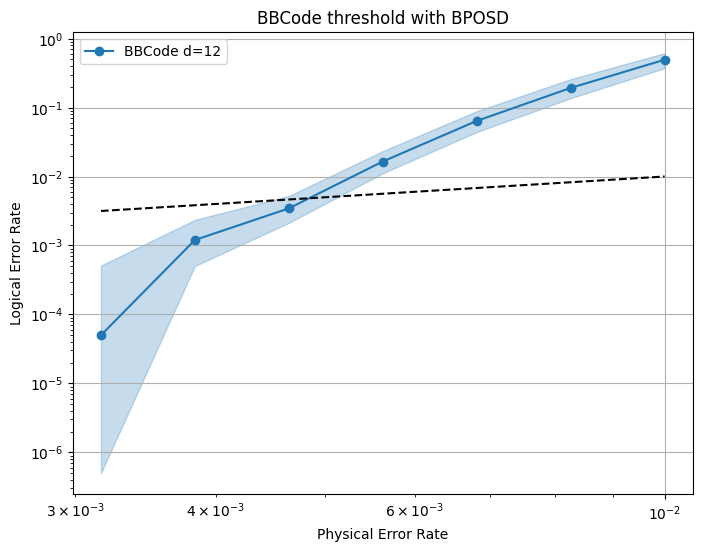

In [19]:
plot_results(samples)

# Code Archive

In [ ]:
def stim_steane_code(error_rate):
# steane code metadata
    steane_code = qldpc.codes.SteaneCode()
    code = steane_code
    repetitions = 10
    stabilizers = []
    
    circuit = cirq.Circuit()
    ancillas = []
    stab_circuit = cirq.Circuit()
    for anc_idx, check in enumerate(code.matrix_x):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        # anc = cirq.LineQubit(7 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CX(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
        
    # circuit += css.barrier(*circuit.all_qubits())
    
    for anc_idx, check in enumerate(code.matrix_z):
        anc = cirq.NamedQubit(f"a{anc_idx + 3}")
        # anc = cirq.LineQubit(7 + 3 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CZ(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
    data = sorted([q for q in stab_circuit.all_qubits() if isinstance(q, cirq.LineQubit)])
    qubits = list(stab_circuit.all_qubits())
    
    circuit = cirq.Circuit()
    for q in qubits:
        # circuit += cirq.R(q)
        circuit += stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q)
    stab_circuit = cirq.Circuit()
    stab_circuit += cirq.Moment([cirq.depolarize(error_rate).on(d) for d in data] + cirq.H.on_each(ancillas))
    stab_circuit += cirq.Circuit(cirq.Moment(stab) for stab in stabilizers)
    stab_circuit += cirq.Moment(cirq.H.on_each(ancillas))
    circuit += stab_circuit
    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    circuit += cirq.Moment(
        stimcirq.DetAnnotation(relative_keys=[-6], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-5], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-4], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-3], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-2], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-1], coordinate_metadata=(12.0, 0.0))
    )
    
    circuit_op = stab_circuit
    circuit_op += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))

    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    moment += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[-len(ancillas) + idx, idx], coordinate_metadata=(len(qubits) + idx, 0)) for idx in range(-len(ancillas), 0)])

    # moment += cirq.Moment(
    #     stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-12, -6], coordinate_metadata=(7.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-11, -5], coordinate_metadata=(8.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-10, -4], coordinate_metadata=(9.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-9, -3], coordinate_metadata=(10.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-8, -2], coordinate_metadata=(11.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-7, -1], coordinate_metadata=(12.0, 0.0))
    # )
    
    circuit_op += moment
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    for idx, d in enumerate(data):
        circuit += cirq.X.with_probability(error_rate).on(d)
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    
    circuit += cirq.Moment(
        stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
        stimcirq.DetAnnotation(relative_keys=[-13, -1, -2, -3, -4], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-12, -1, -2, -5, -6], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-11, -1, -3, -5, -7], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-10, -1, -2, -3, -4], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-9, -1, -2, -5, -6], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-8, -1, -3, -5, -7], coordinate_metadata=(12.0, 0.0))
    )
    circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(relative_keys=[-1, -2, -3], observable_index=0))
    
    # return circuit.with_noise(cirq.depolarize(noise))
    return circuit